In [ ]:
pip install qiskit qiskit_aer



---
# Imports


---



In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import *
from numpy import pi
import numpy as np
from qiskit_aer import Aer
from qiskit import transpile
import random
import matplotlib.pyplot as plt



---

# Variable Definition

---



In [10]:
#A function for generating a random sequense
def generate_random_sequence(length):
    return [random.randint(0, 1) for _ in range(length)]
#The length of the sequence
length=64
BitSequence= generate_random_sequence(length)
AliceBases = generate_random_sequence(length)
BobBases = generate_random_sequence(length)
EveBases = generate_random_sequence(length)
theta_degrees = 25.84193276 # Example value of theta in degrees
theta_radians = np.radians(theta_degrees)  # Convert degrees to radians



---

# Noise And Error Correction

---



In [7]:
# --- All Noise Related Functions ---
def generate_random_angle():
    # Generate a random number from a Gaussian distribution
    # Parameters
    mu = 0  # Mean of the Gaussian distribution
    sigma = 0.15 # Standard deviation of the Gaussian distribution
    while True:
        angle = np.random.normal(mu, sigma)
        if -np.pi <= angle <= np.pi:
            break
    return angle
def generate_custom_random():
    # Define the probabilities for each number
    probabilities = [1/25**i for i in range(1, 9)]

    # Normalize probabilities to sum to 1
    probabilities = [p / sum(probabilities) for p in probabilities]

    # Generate a random integer using the defined probabilities
    return np.random.choice(np.arange(1, 9), p=probabilities)
def TarqetNoise(number):
  if number == 1:
    return [8];
  elif number == 2:
    return [8,3]
  else:
    return [8,0,3]
def BitNoise(cir):
    for i in TarqetNoise(generate_custom_random()):
      cir.rx(np.radians(10),i)
    return cir
def PhaseNoise(cir):
    for i in TarqetNoise(generate_custom_random()):
      cir.rz(np.radians(10),i)
    return cir
#This function uses one Logical qubit to encode 8 other qubits so that we can use it for bit and phase flip encoding
def Encoding(cir):
    # Phase- flip
    cir.cx(8,5)
    cir.cx(8,2)
    cir.h(2)
    cir.h(5)
    cir.h(8)
    #Bit-flip
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    return cir
#This function Decodes the qubits so it can be used again
def Decoding(cir):
    #Bit-flip
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    #Phase-flip
    cir.h(2)
    cir.h(5)
    cir.h(8)
    cir.cx(8,5)
    cir.cx(8,2)
    return cir
#Its time for bit flip for that we use a parity check function
def BitParityCheck(cir,SQubit,AuxQubit):
    cir.cx(SQubit,AuxQubit)
    cir.cx(SQubit+1,AuxQubit)
    cir.cx(SQubit+1,AuxQubit+1)
    cir.cx(SQubit+2,AuxQubit+1)
    return cir
#And We need a CorrectionBlock
def BitCorrectionBlock(cir,SQubit,AuxQubit):
    cir.x(AuxQubit)
    cir.ccx(AuxQubit+1,AuxQubit,SQubit+2)
    cir.x(AuxQubit)
    cir.ccx(AuxQubit+1,AuxQubit,SQubit+1)
    cir.x(AuxQubit+1)
    cir.ccx(AuxQubit+1,AuxQubit,SQubit)
    cir.x(AuxQubit+1)
    cir.measure(AuxQubit,AuxQubit)
    cir.measure(AuxQubit+1,AuxQubit+1)
    cir.reset(AuxQubit)
    cir.reset(AuxQubit+1)
    return cir
#Now bringing it all toghether we construct the Error Correction function
def BitErrorCorrection(cir,AuxQubit):
    for i in range(3):
        cir = BitParityCheck(cir,i*3,AuxQubit)
        cir.barrier()
        cir = BitCorrectionBlock(cir,i*3,AuxQubit)
    return cir
def PhaseParityCheck(cir,AuxQubit):
    #Storing the data in Q8,5,2
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    cir.h(2)
    cir.h(5)
    cir.h(8)
    #Getting the parity stored in the Aux Qubits
    cir.cx(2,AuxQubit)
    cir.cx(5,AuxQubit)
    cir.cx(5,AuxQubit+1)
    cir.cx(8,AuxQubit+1)
    #restoring the Encoded Form
    cir.h(2)
    cir.h(5)
    cir.h(8)
    cir.cx(8,6)
    cir.cx(8,7)
    cir.cx(5,3)
    cir.cx(5,4)
    cir.cx(2,0)
    cir.cx(2,1)
    return cir
def PhaseCorrectionBlock(cir,AuxQubit):
    cir.x(AuxQubit)
    cir.ccz(AuxQubit+1,AuxQubit,8)
    cir.x(AuxQubit)
    cir.ccz(AuxQubit+1,AuxQubit,5)
    cir.x(AuxQubit+1)
    cir.ccz(AuxQubit+1,AuxQubit,2)
    cir.x(AuxQubit+1)
    cir.measure(AuxQubit,AuxQubit)
    cir.measure(AuxQubit+1,AuxQubit+1)
    cir.reset(AuxQubit)
    cir.reset(AuxQubit+1)
    return cir
def PhaseErrorCorrection(cir,AuxQubit):
    cir = PhaseParityCheck(cir,AuxQubit)
    cir.barrier()
    cir = PhaseCorrectionBlock(cir,AuxQubit)
    return cir



---

# BB84 functions

---



In [4]:
# ---- All the functions that provide a noise-less BB84 Protocol with Alligment Error ----

def AlligmentError(cir,bit,basis,theta_radians):
#This is gettingready but with Alligment error
  cir.ry(theta_radians,8)
  if bit == 1:
    cir.x(8)
  if basis == 1:
    cir.h(8)
  return cir
def GettingReady(cir,bit,basis):
    if bit == 1:
        print("bit is 1")
        cir.x(8)
    if basis == 1:
        print("base is +-45")
        cir.h(8)
    return cir
def MeasureSinglePhoton(cir):
    # Use Aer's qasm_simulator
    simulator = Aer.get_backend('qasm_simulator')
    # Execute the circuit on the qasm simulator
    new_circuit = transpile(cir, simulator)
    job = simulator.run(new_circuit, shots = 1)
    # Grab results from the job
    result = job.result()
    # Return counts
    counts = result.get_counts(cir)
    return counts
def ExctarctKey(Checked_List):
  length = len(Checked_List)
  result = []
  for d in Checked_List:
      new_d = {}
      for key, value in d.items():
          third_bit = key[2]  # Extract the third bit from the left
          new_d[third_bit] = value
      result.append(new_d)
  output_string = ""
  for d in result:
    key = list(d.keys())[0]  # Extract the key from the dictionary
    output_string += key
  return output_string
def SendSinglePhoton(cir,BNoise,PNoise):
    cir = Encoding(cir)
    if BNoise:
      cir = BitNoise(cir)
      cir = BitErrorCorrection(cir,9)
    if PNoise:
      cir = PhaseNoise(cir)
      cir = PhaseCorrectionBlock(cir,9)
    return cir
def ReciviengSinglePhoton(cir,BobBasis):
    cir = Decoding(cir)
    #print("Bob Basis is : ", BobBasis)
    if BobBasis == 1:
        #print("Bob Basis is +-45")
        cir.h(8)
    cir.barrier()
    cir.measure([0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10])
    return cir
def BB84(BitSequence,AliceBases,BobBases,EveBases,length,theta_radians,Eve):
   ListOfCounts = []
   EveListOfCounts = []
   if Eve==True:
    for i in range(length):
        circuit = QuantumCircuit(11,11)
        #Getting that one photon with Alice's Basis ready to send
        circuit = AlligmentError(circuit,BitSequence[i],AliceBases[i],2*theta_radians)
        #Sending Single photon
        circuit = SendSinglePhoton(circuit,False,False)
        #Recive Single Photon
        circuit = ReciviengSinglePhoton(circuit,EveBases[i])
        #Measure one Photon with Bob Basis
        counts = MeasureSinglePhoton(circuit)
        EveListOfCounts.append(counts)
        del circuit
    output_string = ExctarctKey(EveListOfCounts)
    list_from_Key = [int(char) for char in output_string]
    ListOfCounts = []
    for i in range(length):
        #print("for bit number : ", i)
        circuit = QuantumCircuit(11,11)
        #Getting that one photon with Alice's Basis ready to send
        circuit = AlligmentError(circuit,list_from_Key[i],EveBases[i],2*theta_radians)
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        circuit = SendSinglePhoton(circuit,False,False)
        #Recive Single Photon
        circuit = ReciviengSinglePhoton(circuit,BobBases[i])
        #Measure one Photon with Bob Basis
        counts = MeasureSinglePhoton(circuit)
        ListOfCounts.append(counts)
        #print("-----------")
        del circuit
    Check_list = []
    EveCheck_list = []
    for i in range(len(ListOfCounts)):
        if AliceBases[i] == BobBases[i]:
            Check_list.append(ListOfCounts[i])
            EveCheck_list.append(EveListOfCounts[i])
    #print("The Bases checked list is : ",Check_list)
    output_string= ExctarctKey(Check_list)
    Eveoutput_string= ExctarctKey(EveCheck_list)
    return  output_string , Eveoutput_string
   else:
    for i in range(length):
        #print("for bit number : ", i)
        circuit = QuantumCircuit(11,11)
        #Getting that one photon with Alice's Basis ready to send
        circuit = AlligmentError(circuit,BitSequence[i],AliceBases[i],2*theta_radians)
        #circuit = GettingReady(circuit,BitSequence[i],AliceBases[i])
        #Sending Single photon
        circuit = SendSinglePhoton(circuit,False,False)
        #Recive Single Photon
        circuit = ReciviengSinglePhoton(circuit,BobBases[i])
        #Measure one Photon with Bob Basis
        counts = MeasureSinglePhoton(circuit)
        ListOfCounts.append(counts)
        #print("-----------")
        del circuit
    #Now Alice and Bob share their Bases
    #print("Raw List of count is : ",ListOfCounts)
    Check_list = []
    for i in range(len(ListOfCounts)):
        if AliceBases[i] == BobBases[i]:
            Check_list.append(ListOfCounts[i])
    #print("The Bases checked list is : ",Check_list)
    output_string= ExctarctKey(Check_list)
    return  output_string
#Alice And Bob Share Some of their Key to check the Seciruty
def CheckSecurity(Key,Akey,Checklength):
    if Akey[-Checklength:] == Key[-Checklength:]:
        print("The Connection is Secure with the probability of:")
        print((1-((3/4)**Checklength))*100)
    else:
        print("The Connection is not Secure!")
def AliceKey(Bit,AliceBases,BobBases):
    Check_list = []
    for i in range(len(Bit)):
        if AliceBases[i] == BobBases[i]:
            Check_list.append(Bit[i])
        Key = ''
    for item in Check_list:
        Key = Key + str(item)
    return Key



---

# Basic Results

---



In [8]:
Key = BB84(BitSequence,AliceBases,BobBases,EveBases,length,theta_radians,False)
print("your Key is :")
print(Key)
alicekey = AliceKey(BitSequence,AliceBases,BobBases)
print("Alice's Key is :")
print(alicekey)
CheckSecurity(Key,alicekey,15)


your Key is :
01110100011000101100100011001100101001101000110110000010100101011011
Alice's Key is :
01100100010001000101001011101100100000101100110101101001100101001111
The Connection is not Secure!


In [9]:
Key2,EveKey =BB84(BitSequence,AliceBases,BobBases,EveBases,length,0,True)
print("your Key is :")
print(Key2)
print("Eve's Key is :")
print(EveKey)
print("Alice's Key is :")
print(alicekey)
CheckSecurity(Key2,alicekey,15)
CheckSecurity(EveKey,Key2,15)

your Key is :
01110101010010011101111010101100000010101100000001100000000100100011
Eve's Key is :
01010111010001010101111111001100111010101100011111100001001100001011
Alice's Key is :
01100100010001000101001011101100100000101100110101101001100101001111
The Connection is not Secure!
The Connection is not Secure!




---

# Error analysis

---



In [11]:
#This Functions are for analizing our results

def calculate_error_rate(results, alicekey):
    error_rates = []
    sums = 0
    results_length = len(results)
    key_length = len(alicekey)

    for result in results:
        # Compare each character in the strings and count the number of differences
        num_errors = sum(bit1 != bit2 for bit1, bit2 in zip(result, alicekey))
        # Calculate the error rate
        error_rate = num_errors / key_length
        sums = sums + error_rate
        error_rates.append(error_rate)

    return max(error_rates) , sums/results_length

In [12]:
aliceKey= AliceKey(BitSequence,AliceBases,BobBases)
CleanResults = []
ResultsWE = []
EveResults = []
CTResults = []
CTResultsWE = []
EveCTResults = []
for _ in range(10):
   # Without Eve and Allignment Error
   result = BB84(BitSequence,AliceBases,BobBases,EveBases,length,0,False)
   CleanResults.append(result)
   #With Eve Without Allignment Error
   resultWE, Everesult = BB84(BitSequence,AliceBases,BobBases,EveBases,length,0,True)
   ResultsWE.append(resultWE)
   EveResults.append(Everesult)
   #With Allignment Error Witout Eve
   CTresult = BB84(BitSequence,AliceBases,BobBases,EveBases,length,theta_radians,False)
   CTResults.append(CTresult)
   #With Eve and Allignment Error
   CTresultWE, EveCTresult = BB84(BitSequence,AliceBases,BobBases,EveBases,length,theta_radians,True)
   CTResultsWE.append(CTresultWE)
   EveCTResults.append(EveCTresult)


In [13]:
CleanError_rates , CleanAverage = calculate_error_rate(CleanResults, aliceKey)
Error_ratesWE , AverageWE = calculate_error_rate(ResultsWE, aliceKey)
EveError_rates , EveAverage = calculate_error_rate(EveResults, aliceKey)
CTError_rates , CTAverage = calculate_error_rate(CTResults, aliceKey)
CTError_ratesWE , CTAverageWE = calculate_error_rate(CTResultsWE, aliceKey)
EveCTError_rates , EveCTAverage = calculate_error_rate(EveCTResults, aliceKey)
print("######Without Eve and Allignment Error######")
print("Max Error rate:", CleanError_rates)
print("Average of error : ", CleanAverage)
print("\n\n######With Eve Without Allignment Error######")
print("Max Error rate:", Error_ratesWE)
print("Average of error : ", AverageWE)
print("Eve's Max Error rate:", EveError_rates)
print("Eve's Average of error : ", EveAverage)
print("\n\n#####Without Eve With Allignment Error#######")
print("Max Error rate:", CTError_rates)
print("Average of error : ", CTAverage)
print("\n\n######With Eve and Allignment Error######")
print("Max Error rate:", CTError_ratesWE)
print("Average of error : ", CTAverageWE)
print("Eve'sMax Error rate:", EveCTError_rates)
print("Eve's Average of error : ", EveCTAverage)

######Without Eve and Allignment Error######
Max Error rate: 0.0
Average of error :  0.0


######With Eve Without Allignment Error######
Max Error rate: 0.4166666666666667
Average of error :  0.3166666666666667
Eve's Max Error rate: 0.3611111111111111
Eve's Average of error :  0.2722222222222222


#####Without Eve With Allignment Error#######
Max Error rate: 0.2777777777777778
Average of error :  0.15833333333333335


######With Eve and Allignment Error######
Max Error rate: 0.4722222222222222
Average of error :  0.3472222222222222
Eve'sMax Error rate: 0.4722222222222222
Eve's Average of error :  0.3833333333333333




---
# HeatMap


---



In [ ]:
def State_Probabilty_Visualization(theta_radians):
  ListOfCounts = []
  ListofBasis = []
  Bits = [0,1]
  SenderBasis = [0,1]
  ReciverBasis = [0,1]
  for SBasis in SenderBasis:
    for  Bit in Bits:
      for RBasis in ReciverBasis:
        BasisCode = ""
        BasisCode = str(Bit)+str(SBasis)+str(RBasis)
        ListofBasis.append(BasisCode)
        circuit = QuantumCircuit(11,11)
        circuit = AlligmentError(circuit,Bit,SBasis,2*theta_radians)
        circuit = SendSinglePhoton(circuit,False,False)
        circuit = ReciviengSinglePhoton(circuit,RBasis)
        counts = MeasureSinglePhoton(circuit)
        for key in counts:
          counts[key] /= 1000
        for NBit in Bits:
          if ('00'+str(NBit)+'00000000') not in counts:
            counts['00'+str(NBit)+'00000000'] = 0.0
        ListOfCounts.append(counts)
  result = []
  for d in ListOfCounts:
      new_d = {}
      for key, value in d.items():
          third_bit = key[2]  # Extract the third bit from the left
          new_d[third_bit] = value
      result.append(new_d)
  propmatrix = np.zeros((4,4))
  j = 0
  k = 0
  for i in result:
    propmatrix[k,j]= i['0']
    propmatrix[k,j+1] = i['1']
    j += 2
    if j >= 4 :
      j = 0
      k += 1
  return propmatrix

In [ ]:
propmat = State_Probabilty_Visualization(theta_radians)

In [ ]:
print(propmat)

[[0.813 0.187 0.898 0.102]
 [0.207 0.793 0.89  0.11 ]
 [0.897 0.103 0.816 0.184]
 [0.889 0.111 0.194 0.806]]


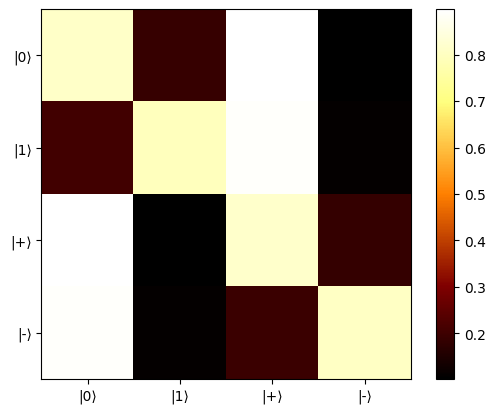

In [ ]:
# Plot the heatmap
plt.imshow(propmat, cmap='afmhot', interpolation='nearest')
plt.xticks(ticks=[0, 1, 2, 3], labels=["|0⟩", "|1⟩", "|+⟩", "|-⟩"])
plt.yticks(ticks=[0, 1, 2, 3], labels=["|0⟩", "|1⟩", "|+⟩", "|-⟩"])

# Add color bar
plt.colorbar()

# Show the plot
plt.show()